In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


seed=5184
np.random.seed(5184)
tf.random.set_seed(5184)

In [2]:
tf.executing_eagerly()
tf.config.list_physical_devices('GPU')

[]

4431872/4422102 [==============================] - 0s 0us/step


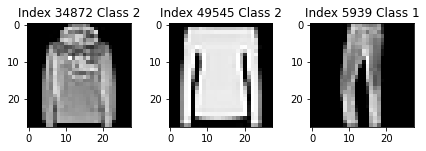

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [5]:
#Normalize Data

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

batch_size=128
lr=0.1

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

print(tf.shape(y_val))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000], shape=(1,), dtype=int32)
tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [7]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device

    self.initial=tf.keras.initializers.he_normal(seed=seed)
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(self.initial([self.size_input, self.size_hidden1])) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(self.initial([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(self.initial([self.size_hidden2, self.size_hidden3]))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(self.initial([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))

    self.gamma1=tf.Variable(tf.ones([1, self.size_hidden1]))
    self.beta1=tf.Variable(tf.zeros([1, self.size_hidden1]))

    self.gamma2=tf.Variable(tf.ones([1, self.size_hidden2]))
    self.beta2=tf.Variable(tf.zeros([1, self.size_hidden2]))

    self.gamma3=tf.Variable(tf.ones([1, self.size_hidden3]))
    self.beta3=tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma1, self.beta1, self.gamma2, self.beta2, self.gamma3, self.beta3]

    self.mean1=tf.Variable(tf.zeros([1, self.size_hidden1]))
    self.var1=tf.Variable(tf.ones([1, self.size_hidden1]))
    self.mean2=tf.Variable(tf.zeros([1, self.size_hidden2]))
    self.var2=tf.Variable(tf.ones([1, self.size_hidden2]))
    self.mean3=tf.Variable(tf.zeros([1, self.size_hidden3]))
    self.var3=tf.Variable(tf.ones([1, self.size_hidden3]))

    self.variables_untraining = [self.mean1, self.var1, self.mean2, self.var2, self.mean3, self.var3]

    self.epsilon=0.001

    #self.untrain_variables=[]
  
  def forward(self, X, training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, training)
    else:
      self.y = self.compute_output(X, training)
      
    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    
    return loss_x

  def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
  def compute_output(self, X, training):
    """
    Custom method to obtain output tensor during forward pass
    """
    if training==True:
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      mean1=tf.math.reduce_mean(h1, 0)
      var1=tf.math.reduce_variance(h1, 0)
      h1 = (h1-mean1)/tf.math.sqrt(var1+self.epsilon)*self.gamma1+self.beta1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      mean2=tf.math.reduce_mean(h2, 0)
      var2=tf.math.reduce_variance(h2, 0)
      h2 = (h2-mean2)/tf.math.sqrt(var2+self.epsilon)*self.gamma2+self.beta2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      mean3=tf.math.reduce_mean(h3, 0)
      var3=tf.math.reduce_variance(h3, 0)
      h3 = (h3-mean3)/tf.math.sqrt(var3+self.epsilon)*self.gamma3+self.beta3

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
    elif training==False:
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      mean1=self.mean1
      var1=self.var1
      h1 = (h1-mean1)/tf.math.sqrt(var1+self.epsilon)*self.gamma1+self.beta1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      mean2=self.mean2
      var2=self.var2
      h2 = (h2-mean2)/tf.math.sqrt(var2+self.epsilon)*self.gamma2+self.beta2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      mean3=self.mean3
      var3=self.var3
      h3 = (h3-mean3)/tf.math.sqrt(var3+self.epsilon)*self.gamma3+self.beta3

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4

    return (output)

  def BNLayer(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    self.mean1=tf.math.reduce_mean(h1, 0)
    self.var1=tf.math.reduce_variance(h1, 0)
    h1 = (h1-self.mean1)/tf.math.sqrt(self.var1+self.epsilon)*self.gamma1+self.beta1
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    self.mean2=tf.math.reduce_mean(h2, 0)
    self.var2=tf.math.reduce_variance(h2, 0)
    h2 = (h2-self.mean2)/tf.math.sqrt(self.var2+self.epsilon)*self.gamma2+self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    self.mean3=tf.math.reduce_mean(h3, 0)
    self.var3=tf.math.reduce_variance(h3, 0)
    h3 = (h3-self.mean3)/tf.math.sqrt(self.var3+self.epsilon)*self.gamma3+self.beta3
    
    return

Epoch 0: 
 Val Loss: 2.406646490097046, Val Accuracy: 9.5600004196167
Epoch 1: 
Loss: 0.3566393256187439, Accuracy: 87.01200103759766, Validation Loss: 0.39560219645500183, Validation Accuracy: 85.5999984741211
Epoch 2: 
Loss: 0.3128078579902649, Accuracy: 88.39399719238281, Validation Loss: 0.3627564609050751, Validation Accuracy: 86.36000061035156
Epoch 3: 
Loss: 0.2825682461261749, Accuracy: 89.71800231933594, Validation Loss: 0.34797191619873047, Validation Accuracy: 87.19999694824219
Epoch 4: 
Loss: 0.2680355906486511, Accuracy: 90.11599731445312, Validation Loss: 0.34061527252197266, Validation Accuracy: 87.37999725341797
Epoch 5: 
Loss: 0.25107336044311523, Accuracy: 90.86599731445312, Validation Loss: 0.34139198064804077, Validation Accuracy: 87.80000305175781
Epoch 6: 
Loss: 0.23138123750686646, Accuracy: 91.47599792480469, Validation Loss: 0.33413583040237427, Validation Accuracy: 87.91000366210938
Epoch 7: 
Loss: 0.22537674009799957, Accuracy: 91.74800109863281, Validation L

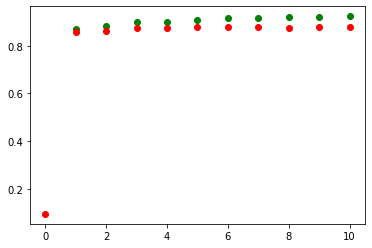

In [10]:
NUM_EPOCHS = 10
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

train_loss.reset_states()
train_accuracy.reset_states()
val_loss.reset_states()
val_accuracy.reset_states()

mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)

valid_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(X_val.shape[0])
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=seed).batch(batch_size)
train_ds_all = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(X_train.shape[0])

for inputs, outputs in valid_ds:
  preds = mlp_on_default.forward(inputs, False)
  val_loss(mlp_on_default.loss(preds,outputs))
  val_accuracy(outputs, preds)

print(
  f'Epoch {0}: \n '
  f'Val Loss: {val_loss.result()}, '
  f'Val Accuracy: {val_accuracy.result() * 100}'
)
plt.plot(0, val_accuracy.result(), 'ro-',label="Validate accuracy")

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*seed).batch(batch_size)
  
  for inputs, outputs in train_ds:
    mlp_on_default.backward(inputs, outputs,opti)
  for inputs, outputs in train_ds_all:
    mlp_on_default.BNLayer(inputs)
  #print(mlp_on_default.variables_untraining[0])

  for inputs, outputs in train_ds_all:
    preds = mlp_on_default.forward(inputs, False)
    train_loss(mlp_on_default.loss(preds,outputs))
    train_accuracy(outputs, preds)

  for inputs, outputs in valid_ds:
    preds = mlp_on_default.forward(inputs, False)
    val_loss(mlp_on_default.loss(preds,outputs))
    val_accuracy(outputs, preds)
  
  print(
    f'Epoch {epoch + 1}: \n'
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Validation Loss: {val_loss.result()}, '
    f'Validation Accuracy: {val_accuracy.result() * 100}'
  )
  plt.plot(epoch + 1, train_accuracy.result(), 'go-',label="Train accuracy")
  plt.plot(epoch + 1, val_accuracy.result(), 'ro-',label="Validate accuracy")

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [11]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

test_loss.reset_states()
test_accuracy.reset_states()

train_ds_all = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(X_train.shape[0])
for inputs, outputs in train_ds_all:
  mlp_on_default.BNLayer(inputs)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(X_test.shape[0])

for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs,False)
  test_loss(mlp_on_default.loss(preds,outputs))
  test_accuracy(outputs, preds)

print(
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}'
)

Test Loss: 0.37356001138687134, Test Accuracy: 87.19000244140625
